In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, avg
import matplotlib.pyplot as plt
import numpy as np

spark_session = SparkSession\
    .builder\
    .master("spark://192.168.2.156:7077") \
    .appName("ProjectGR25")\
    .config("spark.eventLog.enabled", "false")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s")\
    .config("spark.executor.cores", 3)\
    .config("spark.executor.instances", 4)\
    .config("spark.driver.cores", 3)\
    .config("spark.driver.port", 9999)\
    .config("spark.blockManager.port", 10005)\
    .getOrCreate()


spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/19 20:44:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read CSV from hdfs
df = spark_session.read.csv("hdfs://192.168.2.92:9000//spark-data/MillionSongSubset.csv", header=True, inferSchema=True)

# Print Data Frame
df.show()

+--------------------+------------------+--------------------+--------------------+--------------------+-------+-------------------+---------+-------+---+----+--------+------------+------+----+
|           File Path|           Song ID|               Title|              Artist|             Release|  Genre|    Song Hotttnesss| Duration|  Tempo|Key|Mode|Loudness|Danceability|Energy|Year|
+--------------------+------------------+--------------------+--------------------+--------------------+-------+-------------------+---------+-------+---+----+--------+------------+------+----+
|MillionSongSubset...|SOBUDOC12A6D4F8AC2|After All The Lov...|               Alias|               Alias|Unknown|0.38293509007501925|256.67873|120.093|  0|   1| -10.223|         0.0|   0.0|   0|
|MillionSongSubset...|SOLMCFH12A58A7FACE|   Under The Weather|         KT Tunstall|Eye To The Telescope|Unknown| 0.6944535460616664| 216.5024|142.121|  7|   1|  -9.911|         0.0|   0.0|2004|
|MillionSongSubset...|SOOUBMT1

In [4]:
# Show missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

# Danceability 0 for the whole dataset
print(f"Number of entries with Danceability 0: {df.filter(col('Danceability') == 0).count()}")

# Energy 0 for the whole dataset
print(f"Number of entries with Energy 0: {df.filter(col('Energy') == 0).count()}")

# Some of the years are missing (assuming 0 represents missing years)
print(f"Number of entries with missing year value: {df.filter(col('Year') == 0).count()}")

# Genre is 'Unknown' for some entries
print(f"Number of entries with genre Unknown: {df.filter(col('Genre') == 'Unknown').count()}")


+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+
|File Path|Song ID|Title|Artist|Release|Genre|Song Hotttnesss|Duration|Tempo|Key|Mode|Loudness|Danceability|Energy|Year|
+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+
|        0|      0|    1|     0|      0|    0|           4352|       0|    0|  0|   0|       0|           0|     0|   0|
+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+

Number of entries with Danceability 0: 10000
Number of entries with Energy 0: 10000
Number of entries with missing year value: 5320
Number of entries with genre Unknown: 10000


In [5]:
# Drop rows that do not give any information 
df = df.drop("Genre", "Danceability", "Energy")
df.show(5)

+--------------------+------------------+--------------------+------------------+--------------------+-------------------+---------+-------+---+----+--------+----+
|           File Path|           Song ID|               Title|            Artist|             Release|    Song Hotttnesss| Duration|  Tempo|Key|Mode|Loudness|Year|
+--------------------+------------------+--------------------+------------------+--------------------+-------------------+---------+-------+---+----+--------+----+
|MillionSongSubset...|SOBUDOC12A6D4F8AC2|After All The Lov...|             Alias|               Alias|0.38293509007501925|256.67873|120.093|  0|   1| -10.223|   0|
|MillionSongSubset...|SOLMCFH12A58A7FACE|   Under The Weather|       KT Tunstall|Eye To The Telescope| 0.6944535460616664| 216.5024|142.121|  7|   1|  -9.911|2004|
|MillionSongSubset...|SOOUBMT12A8C13DB6D|                90er|        Headliners|  Das Album zum Film|               NULL|347.79383|170.041|  8|   1|  -4.281|2006|
|MillionSongSubs

In [6]:
# Select columns to compute correlation matrix
Corr_max_columns_df = df.select("Tempo", "Duration", "Loudness", "Key", "Mode", "Song Hotttnesss")

In [7]:
# Convert to pandas and Correlation matrix
Corr_max_columns_df_pd = Corr_max_columns_df.toPandas() 
correlation_matrix = Corr_max_columns_df_pd.corr()
print(correlation_matrix)

                    Tempo  Duration  Loudness       Key      Mode  \
Tempo            1.000000 -0.009968  0.179354  0.009821 -0.015578   
Duration        -0.009968  1.000000  0.057247  0.015262 -0.049486   
Loudness         0.179354  0.057247  1.000000  0.050274 -0.045518   
Key              0.009821  0.015262  0.050274  1.000000 -0.172049   
Mode            -0.015578 -0.049486 -0.045518 -0.172049  1.000000   
Song Hotttnesss  0.079031  0.007042  0.226461  0.025952 -0.036909   

                 Song Hotttnesss  
Tempo                   0.079031  
Duration                0.007042  
Loudness                0.226461  
Key                     0.025952  
Mode                   -0.036909  
Song Hotttnesss         1.000000  


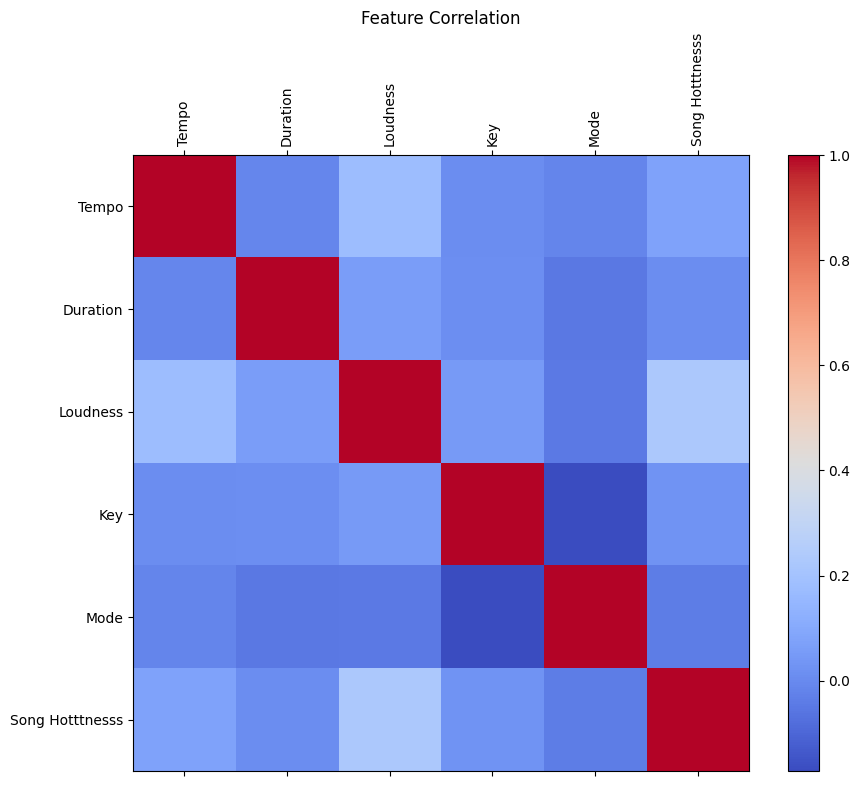

In [8]:
# Plot Correlation Matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap="coolwarm")
plt.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))

ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.index)

plt.title("Feature Correlation")
plt.show()


In [9]:
# Drop duplicates if any
df = df.dropDuplicates()

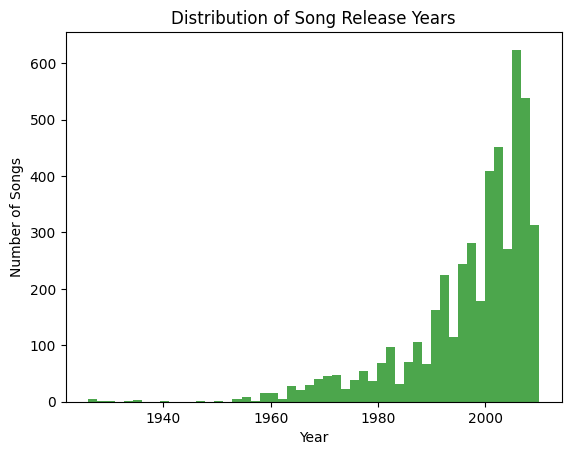

In [10]:
# Select rows that have year values and plot Histogram
filtered_year_df = df.filter(df.Year != 0)
years = filtered_year_df.select("Year").toPandas()

plt.hist(years, bins=50, color="green", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Distribution of Song Release Years")
plt.show()


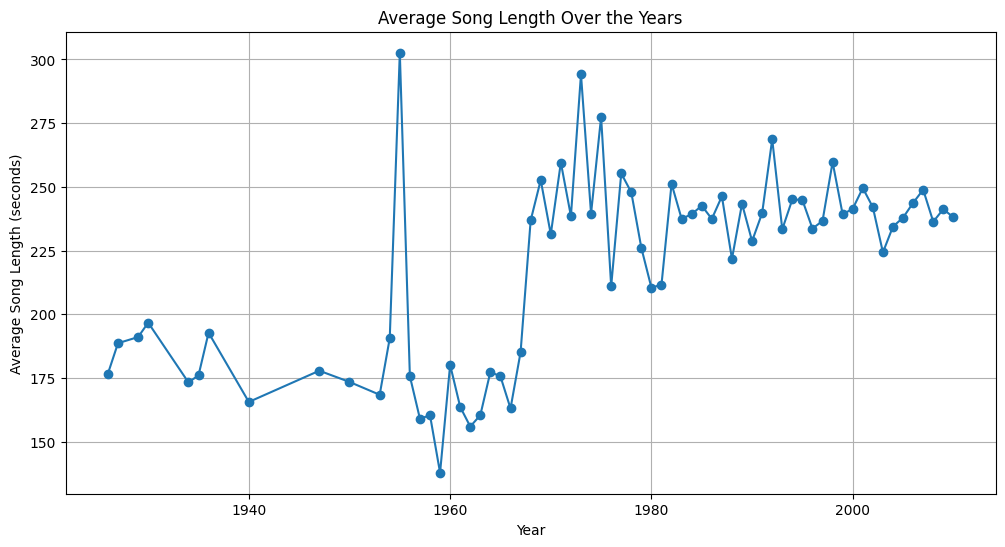

In [12]:
# Group by year and compute average song length
trend_df = filtered_year_df.groupBy("year").agg(avg("duration").alias("average_length"))

# Pandas for plotting
trend_pd = trend_df.toPandas().sort_values(by="year")

# Plot mean times over the years
plt.figure(figsize=(12, 6))
plt.plot(trend_pd["year"], trend_pd["average_length"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Song Length (seconds)")
plt.title("Average Song Length Over the Years")
plt.grid()
plt.show()

In [13]:
spark_context.stop()